# IPWC Bug

@roman_avj
1 Nov 23

Look how to fix the $\hat{G}(t_{n}) == 0$

In [48]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from sklearn.pipeline import Pipeline, make_pipeline
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis, IPCRidge
from sksurv.ensemble import RandomSurvivalForest, ExtraSurvivalTrees, GradientBoostingSurvivalAnalysis
from scipy.integrate import simpson

# Data

## Preprocessing

In [75]:
# read
df_model = pd.read_parquet('../../data/data2analyze_clean_v2.parquet')
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73938 entries, 0 to 73937
Columns: 141 entries, id to cosine_tmonth
dtypes: datetime64[us](2), float64(122), int32(1), int64(4), object(9), string(3)
memory usage: 79.3+ MB


In [76]:
# add if has maintenance
df_model['has_maintenance'] = df_model['cost_of_maintenance'].apply(lambda x: 1 if x > 0 else 0)

In [77]:
# clip columns with 'lag' up to 99 percentile
vars_lag = df_model.columns[df_model.columns.str.contains('lag')]
df_model[vars_lag] = df_model[vars_lag].clip(upper=df_model[vars_lag].quantile(0.99), axis=1)

In [78]:
# select columns
vars_x_categorical = ['listing_type', 'property_type']
vars_x_discrete = ['num_bedrooms', 'sine_tmonth', 'cosine_tmonth']
vars_x_numerical = ['woe_marketplace', 'woe_seller', 'woe_id_sepomex', 
    'first_price', 'diff_first_prediction', 
    'prediction_price_per_square_meter',
    'surface_total', 'page_on_marketplace',
    'is_new_property_prob', 'total_cost_of_living', 'days_active', 'relative_cost_of_living']
vars_x_binary = ['is_exterior', 'has_gym', 'pets_allowed', 'has_maintenance']

vars_x_names = vars_x_categorical + vars_x_numerical + vars_x_binary + vars_x_discrete

# corroborate there are not duplicates in the vars_x_names
print(len(vars_x_names))
print(len(set(vars_x_names)))

21
21


### Train & Test

In [79]:
# get y data as sksurv need
data_y = np.array(
    list(zip(df_model['event'], df_model['time2event'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

# get x data
data_x = (
    df_model.copy()
    .assign(prediction_price=lambda x: x['first_price'].div(1e+6))
    .astype({col: 'category' for col in vars_x_categorical})
    .astype({col: np.float64 for col in vars_x_numerical})
    .astype({col: np.int8 for col in vars_x_binary})
    [vars_x_names]
)
data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73938 entries, 0 to 73937
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   listing_type                       73938 non-null  category
 1   property_type                      73938 non-null  category
 2   woe_marketplace                    73938 non-null  float64 
 3   woe_seller                         73938 non-null  float64 
 4   woe_id_sepomex                     73938 non-null  float64 
 5   first_price                        73938 non-null  float64 
 6   diff_first_prediction              73938 non-null  float64 
 7   prediction_price_per_square_meter  73938 non-null  float64 
 8   surface_total                      73938 non-null  float64 
 9   page_on_marketplace                73938 non-null  float64 
 10  is_new_property_prob               73938 non-null  float64 
 11  total_cost_of_living               73938 

In [80]:
# one hot encoding
data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.info()

colnames_x_numeric = data_x_numeric.columns
data_x_numeric = data_x_numeric.to_numpy()

# boxcox
location_cols_boxcox = [colnames_x_numeric.get_loc(col) for col in vars_x_numerical]

data_x_numeric_aux = data_x_numeric[:, location_cols_boxcox] / 1e+6
data_x_numeric_aux = PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(data_x_numeric_aux)
data_x_numeric[:,location_cols_boxcox] = data_x_numeric_aux

# scale
location_cols_scale = [colnames_x_numeric.get_loc(col) for col in vars_x_discrete]
data_x_numeric_aux = data_x_numeric[:, location_cols_scale]
data_x_numeric_aux = StandardScaler().fit_transform(data_x_numeric_aux)
data_x_numeric[:,location_cols_scale] = data_x_numeric_aux

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73938 entries, 0 to 73937
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   listing_type=for-sale              73938 non-null  float64
 1   property_type=house                73938 non-null  float64
 2   woe_marketplace                    73938 non-null  float64
 3   woe_seller                         73938 non-null  float64
 4   woe_id_sepomex                     73938 non-null  float64
 5   first_price                        73938 non-null  float64
 6   diff_first_prediction              73938 non-null  float64
 7   prediction_price_per_square_meter  73938 non-null  float64
 8   surface_total                      73938 non-null  float64
 9   page_on_marketplace                73938 non-null  float64
 10  is_new_property_prob               73938 non-null  float64
 11  total_cost_of_living               73938 non-null  flo

In [81]:
# split train & test
X_train, X_test, y_train, y_test = train_test_split(
    data_x_numeric, data_y, test_size=0.2, random_state=42, stratify=data_x['listing_type']
)

# Validate IPWC metric

In [56]:
from sksurv.nonparametric import kaplan_meier_estimator, ipc_weights, CensoringDistributionEstimator

# ipc weights
ipc_weights_train = ipc_weights(y_train['Status'], y_train['Survival_in_days'])

AssertionError: 

In [58]:
# censoring distribution
cde = CensoringDistributionEstimator()
cde.fit(y_train)
cde_train = cde.predict_ipcw(y_train)


ValueError: censoring survival function is zero at one or more time points

In [14]:
y_train[:5]

array([(False,  26.), (False, 154.), ( True,  74.), ( True,  20.),
       ( True,  85.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [15]:
y_train[:3]

array([(False,  26.), (False, 154.), ( True,  74.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

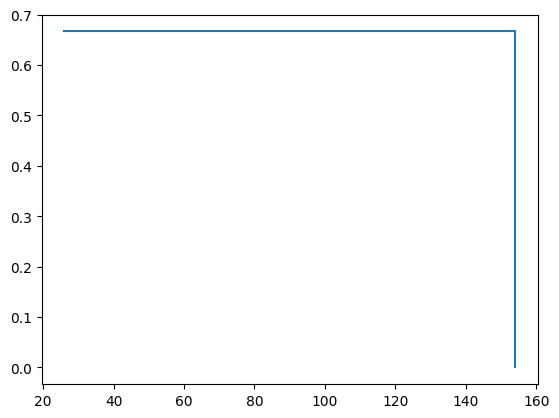

In [16]:
# get censoring survival function
km = kaplan_meier_estimator(y_train['Status'][:3], y_train['Survival_in_days'][:3], reverse=True)

# plot censoring survival function
plt.step(km[0], km[1], where="post")

In [17]:
km[1][-2]

0.6666666666666667

### Look if last time for train and test are observed

In [18]:
# look last time in train
imax = np.argmax(y_train['Survival_in_days'])
y_train[imax]

(False, 178.)

In [19]:
# look last time in train
imax = np.argmax(y_test['Survival_in_days'])
y_test[imax]

(False, 178.)

In [20]:
# sort train by time
y_train_aux = np.sort(y_train, order=['Survival_in_days'])
y_train_aux[-10:-1]

array([(False, 178.), (False, 178.), (False, 178.), (False, 178.),
       (False, 178.), ( True, 178.), ( True, 178.), ( True, 178.),
       ( True, 178.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

## Look by hand

In [96]:
event, time = y_train['Status'], y_train['Survival_in_days']
unique_time, p = kaplan_meier_estimator(event, time, reverse=True)

idx = np.searchsorted(unique_time, time[event])
Ghat = p[idx]

In [90]:
print(np.sort(time))
print("\n")
print(np.sort(time[event]))
print(np.sort(time[~event]))

[  5.   5.   5. ... 178. 178. 178.]


[  5.   5.   5. ... 178. 178. 178.]
[  5.   5.   5. ... 178. 178. 178.]


In [84]:
print(unique_time.shape)
print(unique_time)

(174,)
[  5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.
  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.
  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.
  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102.
 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130.
 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.
 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158.
 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172.
 173. 174. 175. 176. 177. 178.]


In [85]:
print(p)

[0.9999154  0.99874223 0.99840099 0.99752529 0.99480738 0.990766
 0.98728349 0.98397652 0.97098643 0.96914371 0.96696527 0.96326909
 0.95878966 0.95374596 0.94802364 0.9427611  0.94061139 0.93922452
 0.93535759 0.92824113 0.92152398 0.91448155 0.9079468  0.90566807
 0.90422957 0.89968258 0.89293695 0.88598364 0.87945902 0.87341802
 0.8709079  0.8684624  0.86412632 0.85839928 0.84837895 0.84119773
 0.83097447 0.82875743 0.8263068  0.82251021 0.816468   0.81061053
 0.80476344 0.80041689 0.79849972 0.79398315 0.79019795 0.78417664
 0.77969174 0.77537402 0.76792977 0.76582293 0.76383293 0.7603433
 0.7555726  0.74963523 0.74443936 0.73915433 0.73634136 0.73394249
 0.72890116 0.72326045 0.71796858 0.71225623 0.70553609 0.70210903
 0.70010403 0.69606652 0.6899524  0.68434134 0.67917778 0.67284763
 0.67057715 0.66788672 0.66471885 0.65865125 0.65313914 0.647948
 0.64132889 0.63862991 0.63668738 0.63254868 0.62674112 0.61757588
 0.60756975 0.59673053 0.59343815 0.58978319 0.58417399 0.57827622


I think this will work out if I add a sinthetical time to the censoring data, adding only a (max_time + 1, True) 

In [115]:
y_train

array([(False,  26.), (False, 154.), ( True,  74.), ..., ( True,  15.),
       ( True,  75.), ( True,  16.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

# SOLUCIÓN

In [117]:
# create a synthetic time 
ymax = y_train['Survival_in_days'].max()

# append time_synthetic to y_train, be careful with named array (dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
time_synthetic = np.array(
    [(True, ymax + 1)],
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

y_train_synthetic = np.append(y_train, time_synthetic)


In [120]:
event, time = y_train_synthetic['Status'], y_train_synthetic['Survival_in_days']
unique_time, p = kaplan_meier_estimator(event, time, reverse=True)

idx3 = np.searchsorted(unique_time, time[event])
Ghat3 = p[idx3]

In [121]:
(Ghat3 == 0).any()

False

In [122]:
# censoring distribution
cde = CensoringDistributionEstimator()
cde.fit(y_train_synthetic)
cde_train = cde.predict_ipcw(y_train_synthetic)


# Solución ^^^

### Try giving ordered time

In [97]:
y_train_ordered = np.sort(y_train, order=['Survival_in_days'])

event, time = y_train_ordered['Status'], y_train_ordered['Survival_in_days']
unique_time, p = kaplan_meier_estimator(event, time, reverse=True)

idx2 = np.searchsorted(unique_time, time[event])
Ghat2 = p[idx2]

In [105]:
np.sum(Ghat2 == 0)

5

In [104]:
np.sum(Ghat == 0)

5

In [99]:
# censoring distribution
cde = CensoringDistributionEstimator()
cde.fit(y_train_ordered)
cde_train = cde.predict_ipcw(y_train_ordered)

ValueError: censoring survival function is zero at one or more time points

In [106]:
idx.max()

173

# IPC for 

Fit an accelerated IPC Ridge model to the training data

In [21]:
from sksurv.datasets import load_breast_cancer

X, y = load_breast_cancer()
Xt = OneHotEncoder().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=0)

In [ ]:
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss="ipcwls", n_estimators=300, learning_rate=1.0, random_state=0
).fit(X_train, y_train)
cindex = est_aft_ls.score(X_test, y_test)
print(round(cindex, 3))

## Look Censoring

In [22]:
# censoring distribution
cde = CensoringDistributionEstimator()
cde.fit(y_train)
cde_train = cde.predict_ipcw(y_train)

In [24]:
y_train

array([( True, 1731.), (False, 5238.), (False, 5860.), ( True, 7185.),
       ( True, 1171.), (False, 4675.), (False, 5035.), (False, 5651.),
       (False, 5101.), (False, 4555.), (False, 6135.), (False, 3900.),
       (False, 5693.), (False, 5551.), ( True, 1693.), (False, 4691.),
       (False, 6295.), (False, 5612.), (False, 6132.), (False, 4672.),
       (False, 4487.), (False, 4952.), (False, 6298.), (False, 4874.),
       (False, 4866.), (False, 2647.), ( True,  690.), (False, 5571.),
       (False, 5359.), (False, 2225.), (False, 1215.), (False, 5673.),
       (False, 1920.), (False, 5316.), ( True,  524.), (False, 3555.),
       (False, 5530.), (False, 1781.), (False, 5685.), ( True, 1136.),
       (False, 4181.), ( True, 1721.), (False, 2879.), ( True, 1598.),
       (False, 5779.), ( True,  289.), (False, 4681.), (False, 4568.),
       (False, 5768.), ( True, 2454.), ( True,  421.), ( True,  723.),
       (False, 2965.), ( True,  269.), (False, 4596.), (False, 5012.),
      

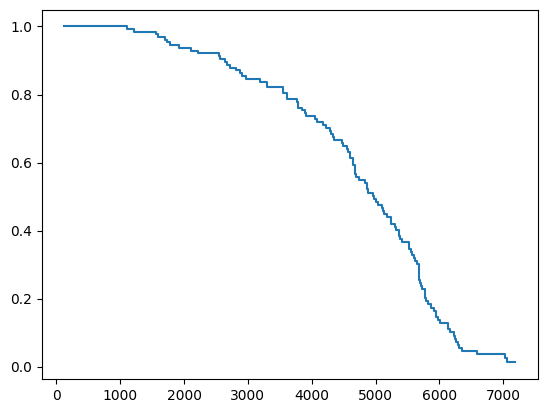

In [25]:
# get censoring survival function
km = kaplan_meier_estimator(y_train['e.tdm'], y_train['t.tdm'], reverse=True)

# plot censoring survival function
plt.step(km[0], km[1], where="post")

In [27]:
km[1][-1]

0.012182263427546974

In [28]:
## look last time in train
imax = np.argmax(y_train['t.tdm'])
y_train[imax]

(True, 7185.)

In [34]:
# sort train by time
y_train_aux = np.sort(y_train, order=['t.tdm'], axis=0)
y_train_aux[-5:]

array([(False, 6591.), ( True, 6777.), (False, 7023.), (False, 7057.),
       ( True, 7185.)], dtype=[('e.tdm', '?'), ('t.tdm', '<f8')])

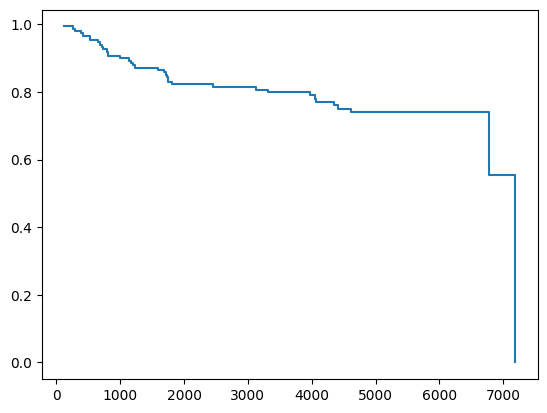

In [35]:
# plot kaplan meier
km = kaplan_meier_estimator(y_train['e.tdm'], y_train['t.tdm'], reverse=False)
plt.step(km[0], km[1], where="post")

### Modify the censoring distribution

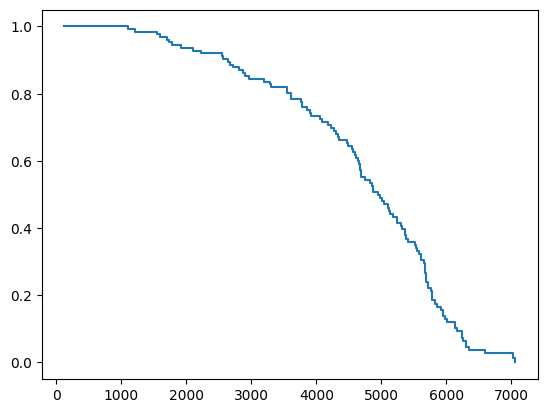

In [43]:
# get rid of the last time
y_train_aux = np.sort(y_train, order=['t.tdm'], axis=0)[:-1]

# get censoring survival function
km = kaplan_meier_estimator(y_train_aux['e.tdm'], y_train_aux['t.tdm'], reverse=True)

# plot censoring survival function
plt.step(km[0], km[1], where="post")

In [41]:
# look last time in train
imax = np.argmax(y_train_aux['t.tdm'])
y_train_aux[imax]

(False, 7057.)

In [42]:
km[1][-1]

0.0

### Look if the new censoring distribution creates problems

In [44]:
# censoring distribution
cde = CensoringDistributionEstimator()
cde.fit(y_train_aux)
cde_train = cde.predict_ipcw(y_train_aux)

In [47]:
y_train_aux

array([( True,  125.), ( True,  269.), ( True,  289.), ( True,  394.),
       ( True,  421.), ( True,  524.), ( True,  528.), ( True,  649.),
       ( True,  690.), ( True,  723.), ( True,  730.), ( True,  796.),
       ( True,  803.), ( True,  805.), ( True,  994.), (False, 1104.),
       ( True, 1136.), ( True, 1171.), ( True, 1206.), (False, 1215.),
       ( True, 1233.), (False, 1554.), (False, 1591.), ( True, 1598.),
       ( True, 1693.), (False, 1703.), ( True, 1721.), ( True, 1731.),
       (False, 1740.), ( True, 1742.), ( True, 1743.), (False, 1781.),
       ( True, 1815.), (False, 1920.), (False, 2105.), (False, 2225.),
       ( True, 2454.), (False, 2549.), (False, 2561.), (False, 2647.),
       (False, 2672.), (False, 2722.), (False, 2809.), (False, 2879.),
       (False, 2909.), (False, 2965.), ( True, 3121.), (False, 3188.),
       (False, 3293.), (False, 3296.), ( True, 3313.), (False, 3544.),
       (False, 3555.), (False, 3608.), (False, 3614.), (False, 3771.),
      

## Look it by hand


In [59]:
event, time = y_train_aux['e.tdm'], y_train_aux['t.tdm']
unique_time, p = kaplan_meier_estimator(event, time, reverse=True)

idx = np.searchsorted(unique_time, time[event])
Ghat = p[idx]

In [64]:
# look unique time & p
print(unique_time)
print(p)

[ 125.  269.  289.  394.  421.  524.  528.  649.  690.  723.  730.  796.
  803.  805.  994. 1104. 1136. 1171. 1206. 1215. 1233. 1554. 1591. 1598.
 1693. 1703. 1721. 1731. 1740. 1742. 1743. 1781. 1815. 1920. 2105. 2225.
 2454. 2549. 2561. 2647. 2672. 2722. 2809. 2879. 2909. 2965. 3121. 3188.
 3293. 3296. 3313. 3544. 3555. 3608. 3614. 3771. 3779. 3782. 3855. 3900.
 3914. 3976. 4050. 4052. 4066. 4085. 4181. 4227. 4279. 4297. 4327. 4352.
 4353. 4415. 4472. 4487. 4555. 4568. 4596. 4603. 4618. 4642. 4652. 4672.
 4675. 4681. 4691. 4744. 4830. 4863. 4866. 4874. 4952. 4980. 5012. 5035.
 5101. 5110. 5137. 5181. 5236. 5238. 5306. 5316. 5359. 5379. 5406. 5519.
 5530. 5551. 5571. 5602. 5612. 5651. 5673. 5678. 5683. 5685. 5693. 5714.
 5723. 5768. 5779. 5785. 5823. 5860. 5909. 5945. 5947. 5984. 6003. 6132.
 6135. 6161. 6232. 6240. 6255. 6295. 6298. 6352. 6591. 6777. 7023. 7057.]
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.  

In [66]:
# look size of p
print(len(p))

144


In [68]:
# look idx
print(len(idx))
print(idx)

36
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  20  23  24  26  27  29  30  32  36  46  50  61  62  64  72  73  80 141]


In [70]:
# look unique time vs time[event]
print(unique_time)
print("\n")
print(time[event])

[ 125.  269.  289.  394.  421.  524.  528.  649.  690.  723.  730.  796.
  803.  805.  994. 1104. 1136. 1171. 1206. 1215. 1233. 1554. 1591. 1598.
 1693. 1703. 1721. 1731. 1740. 1742. 1743. 1781. 1815. 1920. 2105. 2225.
 2454. 2549. 2561. 2647. 2672. 2722. 2809. 2879. 2909. 2965. 3121. 3188.
 3293. 3296. 3313. 3544. 3555. 3608. 3614. 3771. 3779. 3782. 3855. 3900.
 3914. 3976. 4050. 4052. 4066. 4085. 4181. 4227. 4279. 4297. 4327. 4352.
 4353. 4415. 4472. 4487. 4555. 4568. 4596. 4603. 4618. 4642. 4652. 4672.
 4675. 4681. 4691. 4744. 4830. 4863. 4866. 4874. 4952. 4980. 5012. 5035.
 5101. 5110. 5137. 5181. 5236. 5238. 5306. 5316. 5359. 5379. 5406. 5519.
 5530. 5551. 5571. 5602. 5612. 5651. 5673. 5678. 5683. 5685. 5693. 5714.
 5723. 5768. 5779. 5785. 5823. 5860. 5909. 5945. 5947. 5984. 6003. 6132.
 6135. 6161. 6232. 6240. 6255. 6295. 6298. 6352. 6591. 6777. 7023. 7057.]


[ 125.  269.  289.  394.  421.  524.  528.  649.  690.  723.  730.  796.
  803.  805.  994. 1136. 1171. 1206. 1233. 1598.

In [71]:
# look ghat
print(Ghat)

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99242424 0.99242424 0.99242424
 0.98467093 0.96904123 0.96904123 0.96109827 0.96109827 0.95302181
 0.95302181 0.94480611 0.91994279 0.84467474 0.8193345  0.73398716
 0.73398716 0.72524921 0.6633377  0.6633377  0.60881679 0.02767349]


In [72]:
# look which times
print(time[idx])

[ 125.  269.  289.  394.  421.  524.  528.  649.  690.  723.  730.  796.
  803.  805.  994. 1136. 1171. 1206. 1233. 1598. 1693. 1721. 1731. 1742.
 1743. 1815. 2454. 3121. 3313. 3976. 4050. 4066. 4353. 4415. 4618. 6298.]


In [74]:
# print times greater than 6298
print(y_train_aux[y_train_aux['t.tdm'] > 6298])

[(False, 6352.) (False, 6591.) ( True, 6777.) (False, 7023.)
 (False, 7057.)]
